# Introduction
This is the 2021 version of the notebook created by the Information Systems Lab to introduce students of the University of Macedonia, Greece to Machine Learning & Data Science.

The notebook has been created to use in a RAPIDS environment. In particular in has been developed in a 16 vCPUs, GO GB RAM, and 1 NVIDIA Tesla T4 GPU in Google Cloud Platform.

# The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to predict which previously purchased products will be in a user’s next order.

# 1. Import and Reshape Data
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

# 1.1 Import the required packages

In [1]:
# Import packages
import pandas as pd
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
import gc
gc.enable()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# 1.2 Load data from the CSV files
Loading data from Instacart's CSV Files which we have to load into Python.

We first unzip the .zip file downloaded from Kaggle.

In [2]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [3]:
orders = pd.read_csv('input/orders.csv' )
order_products_train = pd.read_csv('input/order_products__train.csv')
order_products_prior = pd.read_csv('input/order_products__prior.csv')
products = pd.read_csv('input/products.csv')
aisles = pd.read_csv('input/aisles.csv')
departments = pd.read_csv('input/departments.csv')

The following DataFrames are:
* orders: This table includes all orders, namely prior, train, and test. It has single primary key (order_id).
* order_products_train: This table includes training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* order_products_prior : This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* products: This table includes all products. It has a single primary key (product_id)
* aisles: This table includes all aisles. It has a single primary key (aisle_id)
* departments: This table includes all departments. It has a single primary key (department_id)

In [4]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [5]:
order_products_train.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [6]:
order_products_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [7]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [8]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [9]:
departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

To reduce the execution time of this Kernel, we will use the following code by uncomment it. This will trim the orders DataFrame and will keep a 10% random sample of the users.

In [10]:
# Command for coding testing - Get 10% of users
orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))]
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
54   2565571        7    prior             1          3                  9   
55   2402008        7    prior             2          1                 19   
56    121053        7    prior             3          0                 18   
57   1695742        7    prior             4          2                 10   
58   3321109        7    prior             5          5                 18   

    days_since_prior_order  
54                     NaN  
55                    30.0  
56                    30.0  
57                     9.0  
58                     3.0

# 1.3 Reshape data
We transform the data in order to facilitate their further analysis. First, we convert character variables into categories so we can use them in the creation of the model. In Python, a categorical variable is called category and has a fixed number of different values.

In [11]:
# Reshape data - Converting character variables into category 
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')

# 1.4 Create a DataFrame (op)
with the orders and the products that have been purchased on prior orders.

Note: The new DataFrame (op) includes only prior orders 

In [12]:
# Merge of orders and order_products_prior
op = orders.merge(order_products_prior, on = 'order_id', how = 'inner')
op.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2565571        7    prior             1          3                  9   
1   2565571        7    prior             1          3                  9   
2   2565571        7    prior             1          3                  9   
3   2565571        7    prior             1          3                  9   
4   2565571        7    prior             1          3                  9   

   days_since_prior_order  product_id  add_to_cart_order  reordered  
0                     NaN       45628                  1          0  
1                     NaN       39275                  2          0  
2                     NaN        6361                  3          0  
3                     NaN       45066                  4          0  
4                     NaN       13249                  5          0

# 2. Create Predictor Variables
Identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:

* User predictors describing the behavior of a user e.g. total number of orders of a user.
* Product predictors describing characteristics of a product e.g. total number of times a product has been purchased.
* User & product predictors describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

# 2.1 Create user predictors
**2.1.1 Number of orders per customer**

In [13]:
user = op.groupby('user_id')[['order_number']].max()
user.columns = ['user_total_orders']
user = user.reset_index()
user.head()

user_id  user_total_orders
0        7                 20
1       14                 13
2       22                 15
3       24                 18
4       29                 18

**2.1.2 How frequent a customer has reordered products**

A ratio which shows for each user to what extent has products have been reordered in the past

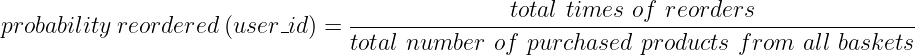

In [14]:
user_reorder = op.groupby('user_id')[['reordered']].mean()
user_reorder.columns = ['user_reordered_ratio']
user_reorder = user_reorder.reset_index()
user_reorder.head()

user_id  user_reordered_ratio
0        7              0.669903
1       14              0.323810
2       22              0.507246
3       24              0.526316
4       29              0.702222

In [15]:
# Merge of user and user_reorder DataFrame
user = user.merge(user_reorder, on='user_id', how='left')
user.head()

user_id  user_total_orders  user_reordered_ratio
0        7                 20              0.669903
1       14                 13              0.323810
2       22                 15              0.507246
3       24                 18              0.526316
4       29                 18              0.702222

In [16]:
# Delete the user_reorder DataFrame
del user_reorder
gc.collect()

199

# 2.2 Create product predictors
**2.2.1 Number of purchases for each product**

We calculate the total number of purchases for each product (from all customers)

In [17]:
prd = op.groupby('product_id')[['order_id']].count()
prd.columns = ['product_total_purchases']
prd = prd.reset_index()
prd.head()

product_id  product_total_purchases
0           1                      205
1           2                       13
2           3                       15
3           4                       37
4           6                        1

**2.2.2 What is the probability for a product to be reordered**

In this section we want to find the products which have the highest probability of being reordered. 

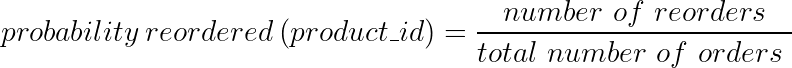

Also, we are going to remove all the products that have less than 40 purchases in order the calculation of the ratio to be meaningful.

In [18]:
# The probability for a product to be reordered
# Remove products with less than 40 purchases & calculate the mean of reorders

product_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
product_reorder = product_reorder.groupby('product_id')[['reordered']].mean()
product_reorder.columns = ['product_reorder_ratio']
product_reorder = product_reorder.reset_index()
product_reorder.head()

product_id  product_reorder_ratio
0           1               0.692683
1          10               0.535849
2          23               0.446809
3          25               0.707819
4          28               0.534247

In [19]:
# Merge of prd and product_reorder DataFrame
prd = prd.merge(product_reorder, on='product_id', how='left')

# Filling out NaN values
prd['product_reorder_ratio'] = prd['product_reorder_ratio'].fillna(value=0)
prd.head()

product_id  product_total_purchases  product_reorder_ratio
0           1                      205               0.692683
1           2                       13               0.000000
2           3                       15               0.000000
3           4                       37               0.000000
4           6                        1               0.000000

In [20]:
# Delete the product_reorder DataFrame
del product_reorder
gc.collect()

88

# 2.3 Create user-product predictors
**2.3.1 How many times a user bought a product**

In [21]:
usxpr = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('usxpr_total_bought')
usxpr = usxpr.reset_index()
usxpr.head()

user_id  product_id  usxpr_total_bought
0        7         274                   1
1        7         519                   2
2        7        4920                   7
3        7        4945                   3
4        7        6361                   5

**2.3.2 How frequently a customer bought a product after its first purchase**

This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to a buy it (starting from her first purchase of the product):

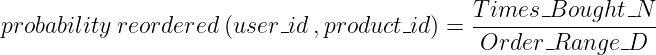

* Times_Bought_N = Times a user bought a product
* Order_Range_D = Total orders placed since the first user's order of a product

For examble: we examine the use with user_id: 1 and the product with product_id: 13032. User 1 has made 10 orders in total. She has bought the product 13032 for first time in her 2nd order and she has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from her 2nd order until her last order). As a result, she has bought it 3 out of 9 times, meaning reorder_ratio=3/9= 0,333.

The Order_Range_D variable is created using two supportive variables:

* Total_orders = Total number of orders of each user
* First_order_number = The order number where the customer bought a product for first time

So, in the next blocks we create:

* The numerator 'Times_Bought_N'
* The denumerator 'Order_Range_D' with the use of the supportive variables 'total_orders' & 'first_order_number'
* Our ratio 'usxpr_order_ratio'


In [22]:
# How frequently a customer bought a product after its first purchase - 'Times_Bought_N'
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
7       274                      1
        519                      2
        4920                     7
        4945                     3
        6361                     5

In [23]:
# Calculate the denumerator - 'Order_Range_D'
total_orders = op.groupby('user_id')[['order_number']].max()
total_orders.columns = ['total_orders']
total_orders = total_orders.reset_index()
total_orders.head()

user_id  total_orders
0        7            20
1       14            13
2       22            15
3       24            18
4       29            18

In [24]:
# Calculate the order number where the user bought a product for first time - 'first_order_number'
first_order_n = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_n = first_order_n.reset_index()
first_order_n.head()

user_id  product_id  first_order_number
0        7         274                   2
1        7         519                   1
2        7        4920                   2
3        7        4945                  16
4        7        6361                   1

In [25]:
# Merge of first_order_n with the total_orders DataFrame and the creation of 'Order_Range_D'
span = pd.merge(total_orders, first_order_n, on='user_id', how='right')
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

user_id  total_orders  product_id  first_order_number  Order_Range_D
0        7            20         274                   2             19
1        7            20         519                   1             20
2        7            20        4920                   2             19
3        7            20        4945                  16              5
4        7            20        6361                   1             20

> **Create the final ratio "usxpr_reorder_ratio"**

In [26]:
usxpr_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
usxpr_ratio['usxpr_reorder_ratio'] = usxpr_ratio.Times_Bought_N / usxpr_ratio.Order_Range_D
usxpr_ratio = usxpr_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
usxpr_ratio.head()

user_id  product_id  usxpr_reorder_ratio
0        7         274             0.052632
1        7         519             0.100000
2        7        4920             0.368421
3        7        4945             0.600000
4        7        6361             0.250000

In [27]:
# Delete temporary DataFrames
del times, first_order_n, span
gc.collect()

88

In [28]:
# Merge of usxpr and usxpr_ratio DataFrame
usxpr = usxpr.merge(usxpr_ratio, on=['user_id', 'product_id'], how='left')
usxpr.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio
0        7         274                   1             0.052632
1        7         519                   2             0.100000
2        7        4920                   7             0.368421
3        7        4945                   3             0.600000
4        7        6361                   5             0.250000

In [29]:
# Delete of usxpr_ratio DataFrame
del usxpr_ratio
gc.collect()

44

**2.3.3 How many times a customer bought a product on its last 5 orders**

For this feature, we want the last five orders for each customer and get how many times bought any product on them.

We need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last five orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.
* Create the following ratio:

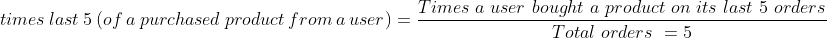

In [30]:
# Variable order_number_back
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2565571        7    prior             1          3                  9   
1   2565571        7    prior             1          3                  9   
2   2565571        7    prior             1          3                  9   
3   2565571        7    prior             1          3                  9   
4   2565571        7    prior             1          3                  9   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN       45628                  1          0   
1                     NaN       39275                  2          0   
2                     NaN        6361                  3          0   
3                     NaN       45066                  4          0   
4                     NaN       13249                  5          0   

   order_number_back  
0                 20  
1                 20  
2                 20  
3                 20  
4                 20

In [31]:
# Keep only the last five orders for each customer
op5 = op[op.order_number_back <= 5]
op5.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
148   2425840        7    prior            16          0                 13   
149   2425840        7    prior            16          0                 13   
150   2425840        7    prior            16          0                 13   
151   2425840        7    prior            16          0                 13   
152   2425840        7    prior            16          0                 13   

     days_since_prior_order  product_id  add_to_cart_order  reordered  \
148                    11.0       37602                  1          1   
149                    11.0       40852                  2          1   
150                    11.0       21137                  3          1   
151                    11.0       17638                  4          1   
152                    11.0       42265                  5          0   

     order_number_back  
148                  5  
149                  5  
150                  5  
151                  5  
152                  5

In [32]:
# How many times each customer bought a product
last_five = op5.groupby(['user_id','product_id'])['order_id'].count().to_frame('last5_times')
last_five.head()

last5_times
user_id product_id             
7       4920                  2
        4945                  3
        8277                  1
        8518                  1
        9598                  1

In [33]:
# Merge of last_five and usxpr DataFrame - Filling out NaN values
usxpr = usxpr.merge(last_five, on=['user_id', 'product_id'], how='left')
usxpr = usxpr.fillna(0)
usxpr.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times
0        7         274                   1             0.052632          0.0
1        7         519                   2             0.100000          0.0
2        7        4920                   7             0.368421          2.0
3        7        4945                   3             0.600000          3.0
4        7        6361                   5             0.250000          0.0

In [34]:
# Delete op5 and last_five DataFrames
del op5 , last_five
gc.collect()

110

In [35]:
# Merge of usxpr and user DataFrame. Store the results on a new DataFrame - data
data = usxpr.merge(user, on='user_id', how='left')
data.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  
0                 20              0.669903  
1                 20              0.669903  
2                 20              0.669903  
3                 20              0.669903  
4                 20              0.669903

In [36]:
# Merge of data with prd 
data = data.merge(prd, on='product_id', how='left')
data.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  
0               0.301724  
1               0.657658  
2               0.666010  
3               0.732888  
4               0.756757

In [37]:
# Delete previous DataFrames
del user, prd, usxpr
gc.collect()

66

# 2.4 What is the average position of a product in a customer's order?
1. We remove the products that have less than 40 purchases in order the calculation of the ratio to be meaningful
2. Groupby 'user_id' and 'product_id' - 'add_to_cart_order' with the .mean() function

In [38]:
mco = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
mco = mco.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().to_frame('mean_add_to_cart_order')
mco = mco.reset_index()
mco.head()

user_id  product_id  mean_add_to_cart_order
0        7         274               16.000000
1        7         519               10.500000
2        7        4920                4.714286
3        7        4945               11.333333
4        7        6361                7.200000

In [39]:
# Merge of data with mco DataFrame
data = data.merge(mco, on=['user_id', 'product_id'], how='left')
data.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  mean_add_to_cart_order  
0               0.301724               16.000000  
1               0.657658               10.500000  
2               0.666010                4.714286  
3               0.732888               11.333333  
4               0.756757                7.200000

# 2.5 Create one_ratio
**2.5.1 How many customers bought a product only once?**

We are going to search the number of users who bought a product only once.

In [40]:
pr_cust = op.groupby(['product_id', 'user_id'])['order_id'].count().to_frame('total')
pr_cust.head()

total
product_id user_id       
1          138          2
           3010         1
           3904         1
           9694        11
           10708        2

In [41]:
# The number of users who bought it only once will have 'total == 1'
total_one = pr_cust[pr_cust.total==1]
total_one.head()

total
product_id user_id       
1          3010         1
           3904         1
           13078        1
           19257        1
           20535        1

In [42]:
# Customers_only_once 
total_one = total_one.groupby('product_id')['total'].count().to_frame('customers_only_once')
total_one.head()

customers_only_once
product_id                     
1                            37
2                             7
3                             5
4                             9
6                             1

> Δηλαδή το προϊόν 1 έχει αγοραστεί μία μόνο φορά από 37 χρήστες ενώ το προϊόν 2 έχει αγοραστεί μία φορά μόνο από 7 χρήστες.

**2.5.2 The number of customers**

We are going to find the total number of customers who bought a product.

In [43]:
pr_cust = pr_cust.reset_index()
customers = pr_cust.groupby('product_id')['user_id'].count().to_frame('total_customers')
customers.head()

total_customers
product_id                 
1                        63
2                        10
3                         8
4                        17
6                         1

> Δηλαδή το προϊόν 4 έχει αγοραστεί από 17 χρήστες ενώ το προϊόν 1 από 63.

In [44]:
# Merge the results
results = pd.merge(total_one, customers, on='product_id', how='right')
results.head()

customers_only_once  total_customers
product_id                                      
1                          37.0               63
2                           7.0               10
3                           5.0                8
4                           9.0               17
6                           1.0                1

**2.5.3 One_ratio**

We are going to research how frequently a user reorder a product.

In [45]:
results['one_ratio'] = results['customers_only_once']/results['total_customers']
results.head(10)

customers_only_once  total_customers  one_ratio
product_id                                                 
1                          37.0               63   0.587302
2                           7.0               10   0.700000
3                           5.0                8   0.625000
4                           9.0               17   0.529412
6                           1.0                1   1.000000
7                           3.0                4   0.750000
8                           7.0                9   0.777778
9                           7.0                8   0.875000
10                         84.0              123   0.682927
11                          4.0                5   0.800000

> Εάν η πιθανότητα του one_ratio είναι μεγάλη σημαίνει ότι οι χρήστες δεν επαναγοράζουν το προϊόν.

In [46]:
# We keep the "one_ratio" column
one = results['one_ratio']
one.head()

product_id
1    0.587302
2    0.700000
3    0.625000
4    0.529412
6    1.000000
Name: one_ratio, dtype: float64

# 2.6 The creation of data Dataframe
All the information from the DataFrames that we have created to store our features (op, user, prd etc.) is now stored on data.

In [47]:
# Merge of data with one DataFrame
data = data.merge(one, on='product_id', how='left')
data.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  mean_add_to_cart_order  one_ratio  
0               0.301724               16.000000   0.771605  
1               0.657658               10.500000   0.631579  
2               0.666010                4.714286   0.469786  
3               0.732888               11.333333   0.418750  
4               0.756757                7.200000   0.407407

In [48]:
# Delete DataFrames
del op, mco, total_one, pr_cust, results, customers, one
gc.collect()

176

# 3. Create train and test DataFrames

**3.1 Include information about the last order of each user**

The data DataFrame (chapter 2.6) should include two more columns which define the type of user (train or test) and the order_id of the future order. This information can be found on the initial orders DataFrame which was provided by Instacart:

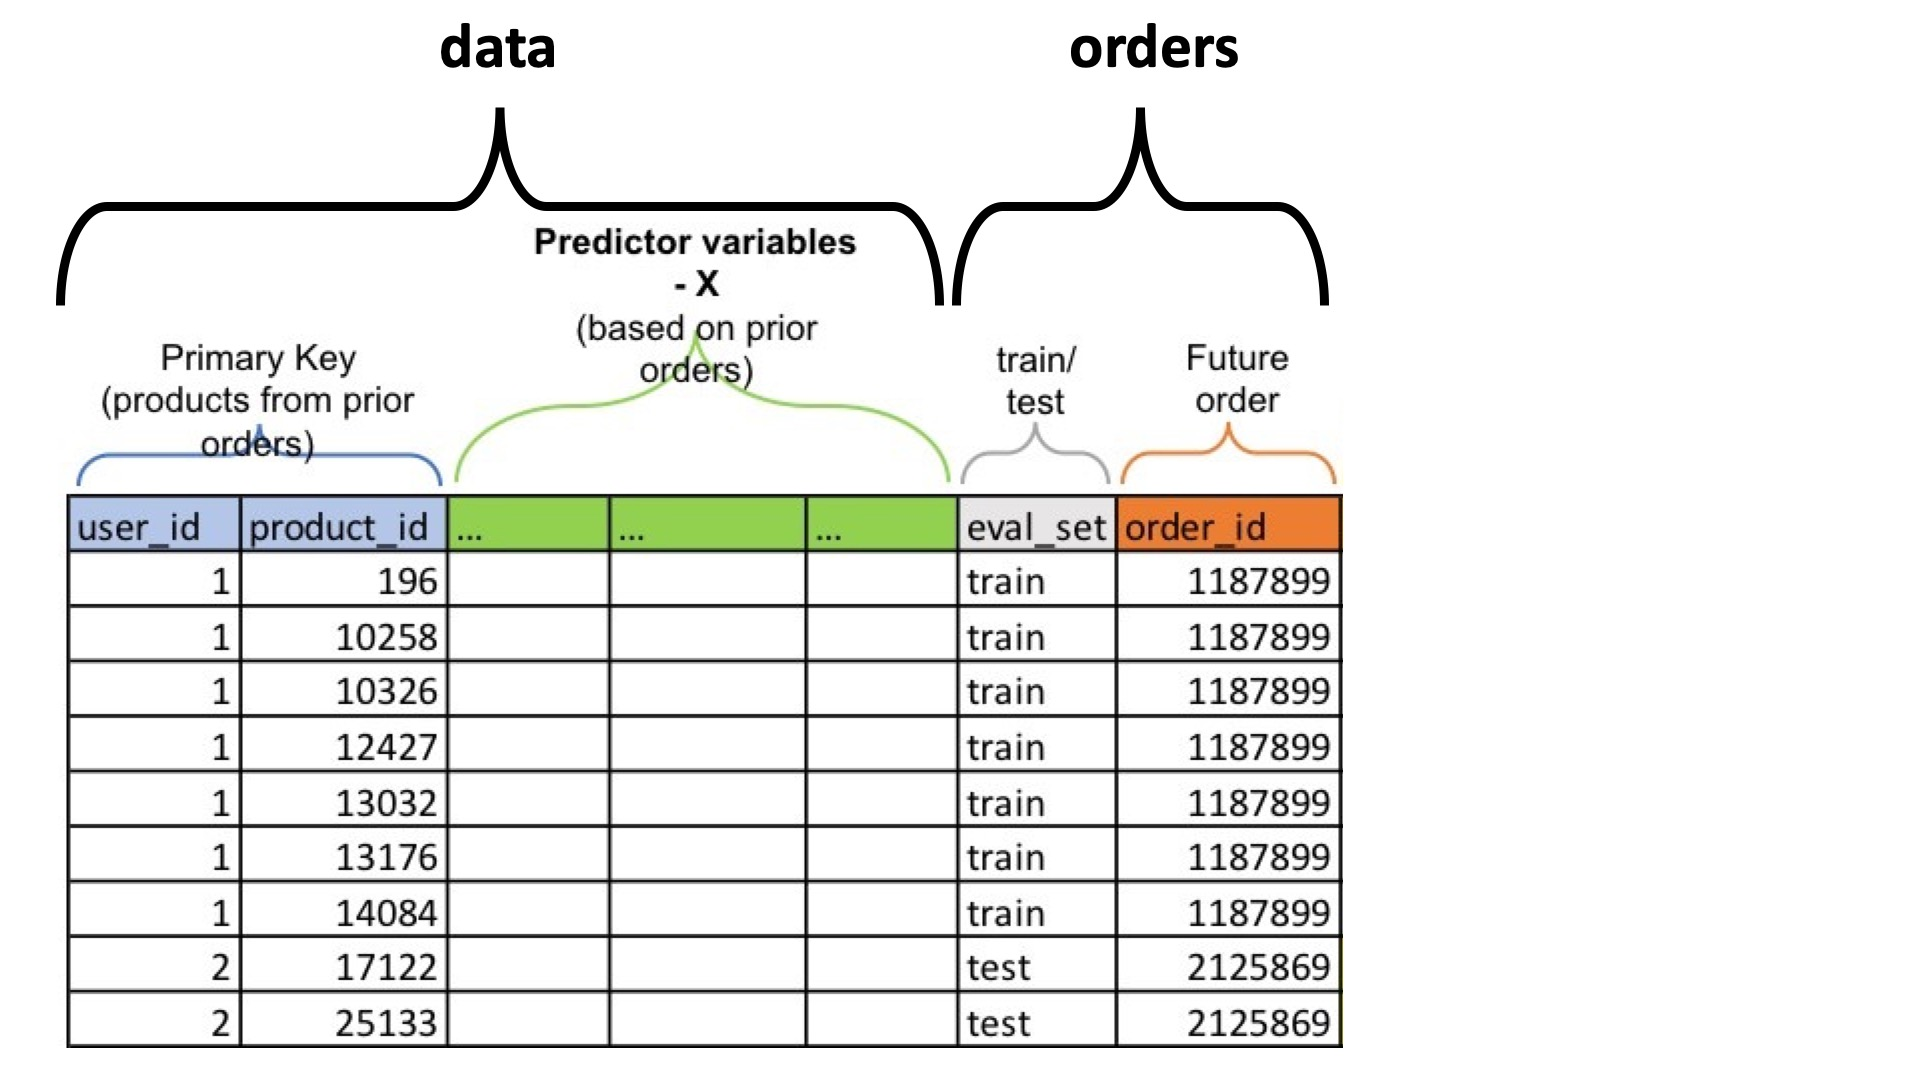

Towards this end:

1. We select the orders DataFrame to keep only the future orders (labeled as "train" & "test).
2. Keep only the columns of our desire ['eval_set', 'order_id'] **AND** 'user_id' as is the matching key with our data DataFrame
3. Merge data DataFrame with the information for the future order of each customer using as matching key the 'user_id'

In [49]:
# Keep only the future orders from all customers: train & test 
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head()

user_id eval_set  order_id
74         7    train    525192
129       14    train   2316178
272       22     test    139655
296       24    train    965160
439       29    train   3110252

In [50]:
# Merge on data DataFrame - Bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  mean_add_to_cart_order  one_ratio eval_set  order_id  
0               0.301724               16.000000   0.771605    train    525192  
1               0.657658               10.500000   0.631579    train    525192  
2               0.666010                4.714286   0.469786    train    525192  
3               0.732888               11.333333   0.418750    train    525192  
4               0.756757                7.200000   0.407407    train    525192

# 3.2 Prepare the train DataFrame

In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

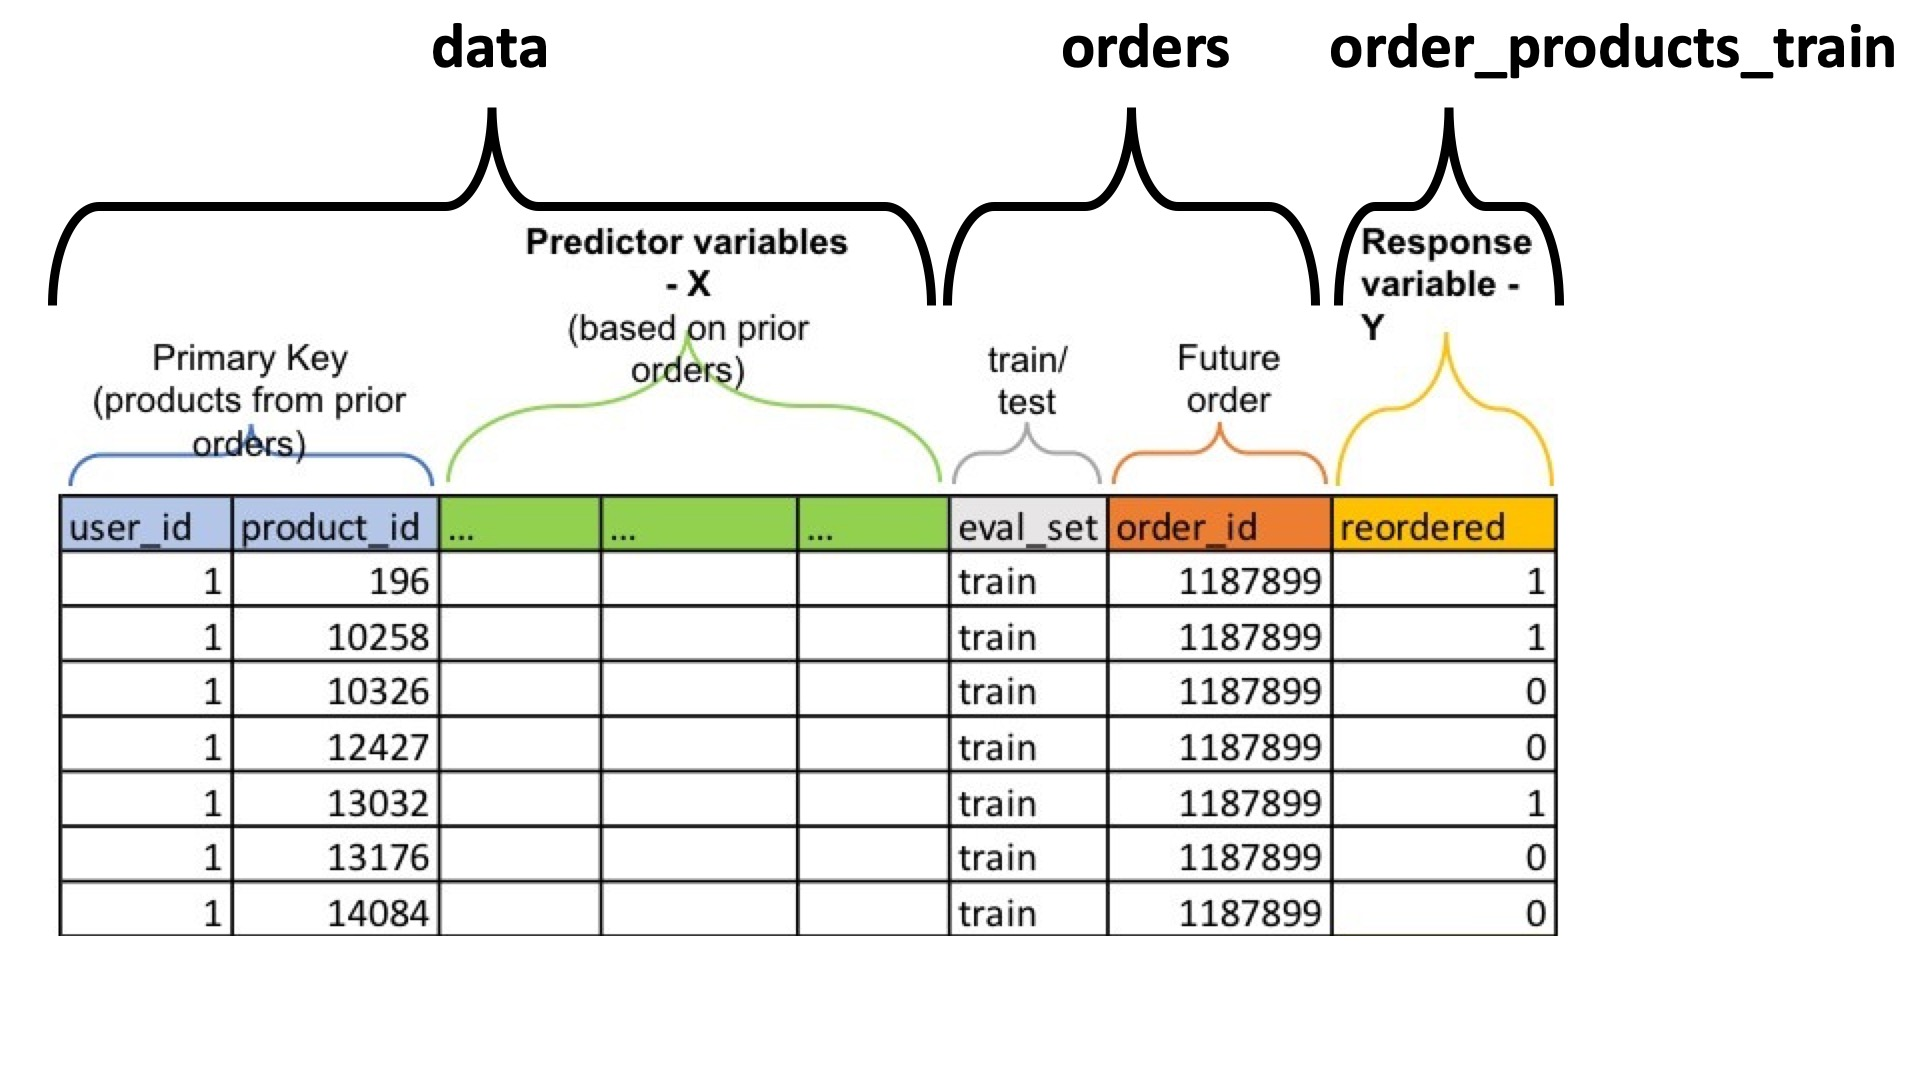

Towards this end:

1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the data DataFrame so to keep only the train users:

In [51]:
# Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  mean_add_to_cart_order  one_ratio eval_set  order_id  
0               0.301724               16.000000   0.771605    train    525192  
1               0.657658               10.500000   0.631579    train    525192  
2               0.666010                4.714286   0.469786    train    525192  
3               0.732888               11.333333   0.418750    train    525192  
4               0.756757                7.200000   0.407407    train    525192

In [52]:
# Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left')
data_train.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  mean_add_to_cart_order  one_ratio eval_set  \
0               0.301724               16.000000   0.771605    train   
1               0.657658               10.500000   0.631579    train   
2               0.666010                4.714286   0.469786    train   
3               0.732888               11.333333   0.418750    train   
4               0.756757                7.200000   0.407407    train   

   order_id  reordered  
0    525192        NaN  
1    525192        NaN  
2    525192        NaN  
3    525192        NaN  
4    525192        NaN

In [53]:
# Fill the NaN values of 'reordered' column
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head()

user_id  product_id  usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
0        7         274                   1             0.052632          0.0   
1        7         519                   2             0.100000          0.0   
2        7        4920                   7             0.368421          2.0   
3        7        4945                   3             0.600000          3.0   
4        7        6361                   5             0.250000          0.0   

   user_total_orders  user_reordered_ratio  product_total_purchases  \
0                 20              0.669903                      232   
1                 20              0.669903                      111   
2                 20              0.669903                     8126   
3                 20              0.669903                      599   
4                 20              0.669903                      333   

   product_reorder_ratio  mean_add_to_cart_order  one_ratio eval_set  \
0               0.301724               16.000000   0.771605    train   
1               0.657658               10.500000   0.631579    train   
2               0.666010                4.714286   0.469786    train   
3               0.732888               11.333333   0.418750    train   
4               0.756757                7.200000   0.407407    train   

   order_id  reordered  
0    525192        0.0  
1    525192        0.0  
2    525192        0.0  
3    525192        0.0  
4    525192        0.0

In [54]:
# Set as index the columns that describe uniquely each row 
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head()

usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
user_id product_id                                                         
7       274                          1             0.052632          0.0   
        519                          2             0.100000          0.0   
        4920                         7             0.368421          2.0   
        4945                         3             0.600000          3.0   
        6361                         5             0.250000          0.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
7       274                        20              0.669903   
        519                        20              0.669903   
        4920                       20              0.669903   
        4945                       20              0.669903   
        6361                       20              0.669903   

                    product_total_purchases  product_reorder_ratio  \
user_id product_id                                                   
7       274                             232               0.301724   
        519                             111               0.657658   
        4920                           8126               0.666010   
        4945                            599               0.732888   
        6361                            333               0.756757   

                    mean_add_to_cart_order  one_ratio eval_set  order_id  \
user_id product_id                                                         
7       274                      16.000000   0.771605    train    525192   
        519                      10.500000   0.631579    train    525192   
        4920                      4.714286   0.469786    train    525192   
        4945                     11.333333   0.418750    train    525192   
        6361                      7.200000   0.407407    train    525192   

                    reordered  
user_id product_id             
7       274               0.0  
        519               0.0  
        4920              0.0  
        4945              0.0  
        6361              0.0

In [55]:
# Remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head()

usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
user_id product_id                                                         
7       274                          1             0.052632          0.0   
        519                          2             0.100000          0.0   
        4920                         7             0.368421          2.0   
        4945                         3             0.600000          3.0   
        6361                         5             0.250000          0.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
7       274                        20              0.669903   
        519                        20              0.669903   
        4920                       20              0.669903   
        4945                       20              0.669903   
        6361                       20              0.669903   

                    product_total_purchases  product_reorder_ratio  \
user_id product_id                                                   
7       274                             232               0.301724   
        519                             111               0.657658   
        4920                           8126               0.666010   
        4945                            599               0.732888   
        6361                            333               0.756757   

                    mean_add_to_cart_order  one_ratio  reordered  
user_id product_id                                                
7       274                      16.000000   0.771605        0.0  
        519                      10.500000   0.631579        0.0  
        4920                      4.714286   0.469786        0.0  
        4945                     11.333333   0.418750        0.0  
        6361                      7.200000   0.407407        0.0

# 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column as it is the label that we want to predict.
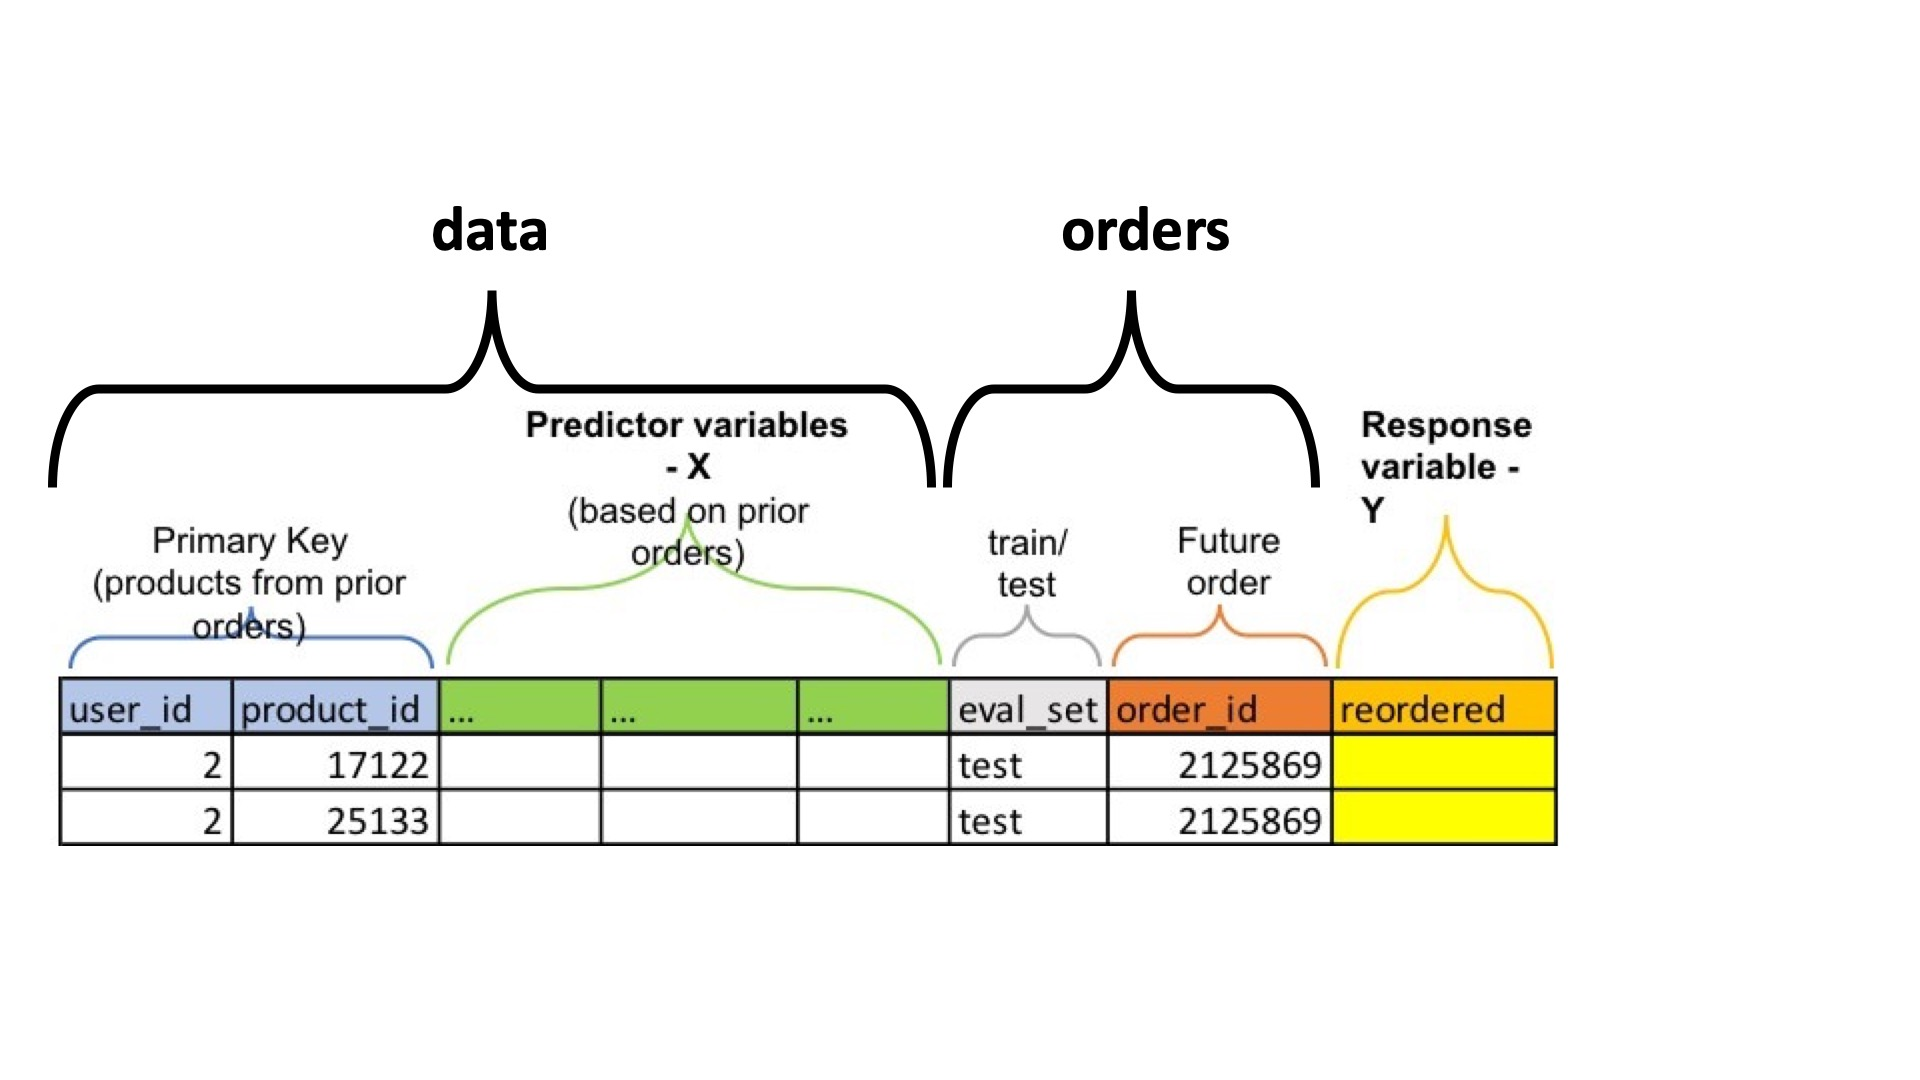

To create it, we:
* Keep only the customers who are labelled as test
* Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")
* Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [56]:
# Keep only the customers who are labelled as test
data_test = data[data.eval_set=='test']

In [57]:
# Set as index the columns that describe each row ("user_id" & "product_id")
data_test = data_test.set_index(['user_id', 'product_id'])

In [58]:
# Remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
data_test.head()

usxpr_total_bought  usxpr_reorder_ratio  last5_times  \
user_id product_id                                                         
22      2452                         2             0.181818          0.0   
        4217                         1             0.333333          1.0   
        4421                         1             0.090909          0.0   
        5212                         1             0.125000          0.0   
        5450                         1             0.125000          0.0   

                    user_total_orders  user_reordered_ratio  \
user_id product_id                                            
22      2452                       15              0.507246   
        4217                       15              0.507246   
        4421                       15              0.507246   
        5212                       15              0.507246   
        5450                       15              0.507246   

                    product_total_purchases  product_reorder_ratio  \
user_id product_id                                                   
22      2452                           1096               0.621350   
        4217                             68               0.558824   
        4421                           1238               0.546042   
        5212                           2379               0.741488   
        5450                           5120               0.680078   

                    mean_add_to_cart_order  one_ratio  
user_id product_id                                     
22      2452                           3.5   0.544578  
        4217                           5.0   0.533333  
        4421                           1.0   0.601423  
        5212                           4.0   0.430894  
        5450                          13.0   0.458486

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.

# 4.1 Train XGBoost
XGBoost stands for **eXtreme Gradient Boosting,** an algorithm that is used in many winning solutions for Kaggle competitions [(ref.)](https://github.com/dmlc/xgboost/blob/aa0d8f20c14107481722b45471287c01109c26d2/demo/README.md)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [59]:
import xgboost as xgb
X, y = data_train.drop('reordered', axis=1), data_train.reordered

We split the datasets in train and test sets in order to ensure that the evaluation of the model is unbiased. We tune the model using the train set and then we evaluate the final model in the test set. We hold 25% of the data for the test set.

IMPORTANT: We split Kaggle's Train Set into train (75%) and test sets (25%).

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

We initially create and finetune the model using the train set. In order to ensure that our model will have low variance and bias we employ repeated k-fold Cross-Validation. Cross-validation (CV) is a popular strategy for algorithm selection. The main idea behind CV is to split data, once or several times, for estimating the risk of each algorithm. Part of data (the training sample) is used for training each algorithm, and the remaining part (the validation sample) is used for estimating the risk of the algorithm. We create stratified folds when performing cross-validation. This has the effect of enforcing the same distribution of classes in each fold as in the whole training dataset when performing the cross-validation evaluation. We perform 5-fold validation, meaning that we create and evaluate 5 models in each round and the final score is the average score of these models

IMPORTANT: We employ GPU by setting: tree_method='gpu_hist', gpu_id=0

In [61]:
paramGrid = {"learning_rate":[0.1], "n_estimators":[600], "max_depth": [5, 6], "subsample": [0.8], "colsample_bytree": [0.6], "colsample_bylevel": [0.6]}  

model = XGBClassifier(nthread=10, tree_method='gpu_hist', gpu_id=0)

cv = StratifiedKFold()

gridsearch = GridSearchCV(model, paramGrid, scoring='roc_auc', cv=cv, verbose=2)

fit = gridsearch.fit(X_train, y_train)

print(fit.best_score_)

print(fit.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:21:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=  10.8s
[16:21:42] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   4.8s
[16:21:47] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   4.8s
[16:21:52] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   4.8s
[16:21:57] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8; total time=   4.8s
[16:22:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   6.2s
[16:22:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   6.1s
[16:22:14] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   6.1s
[16:22:20] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   6.2s
[16:22:26] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bylevel=0.6, colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, subsample=0.8; total time=   6.3s


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:22:32] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1614190077837/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8258520374971484
{'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.8}


In [62]:
fit.score(X_test, y_test)

0.8257643813695237

In [63]:
best = fit.best_estimator_

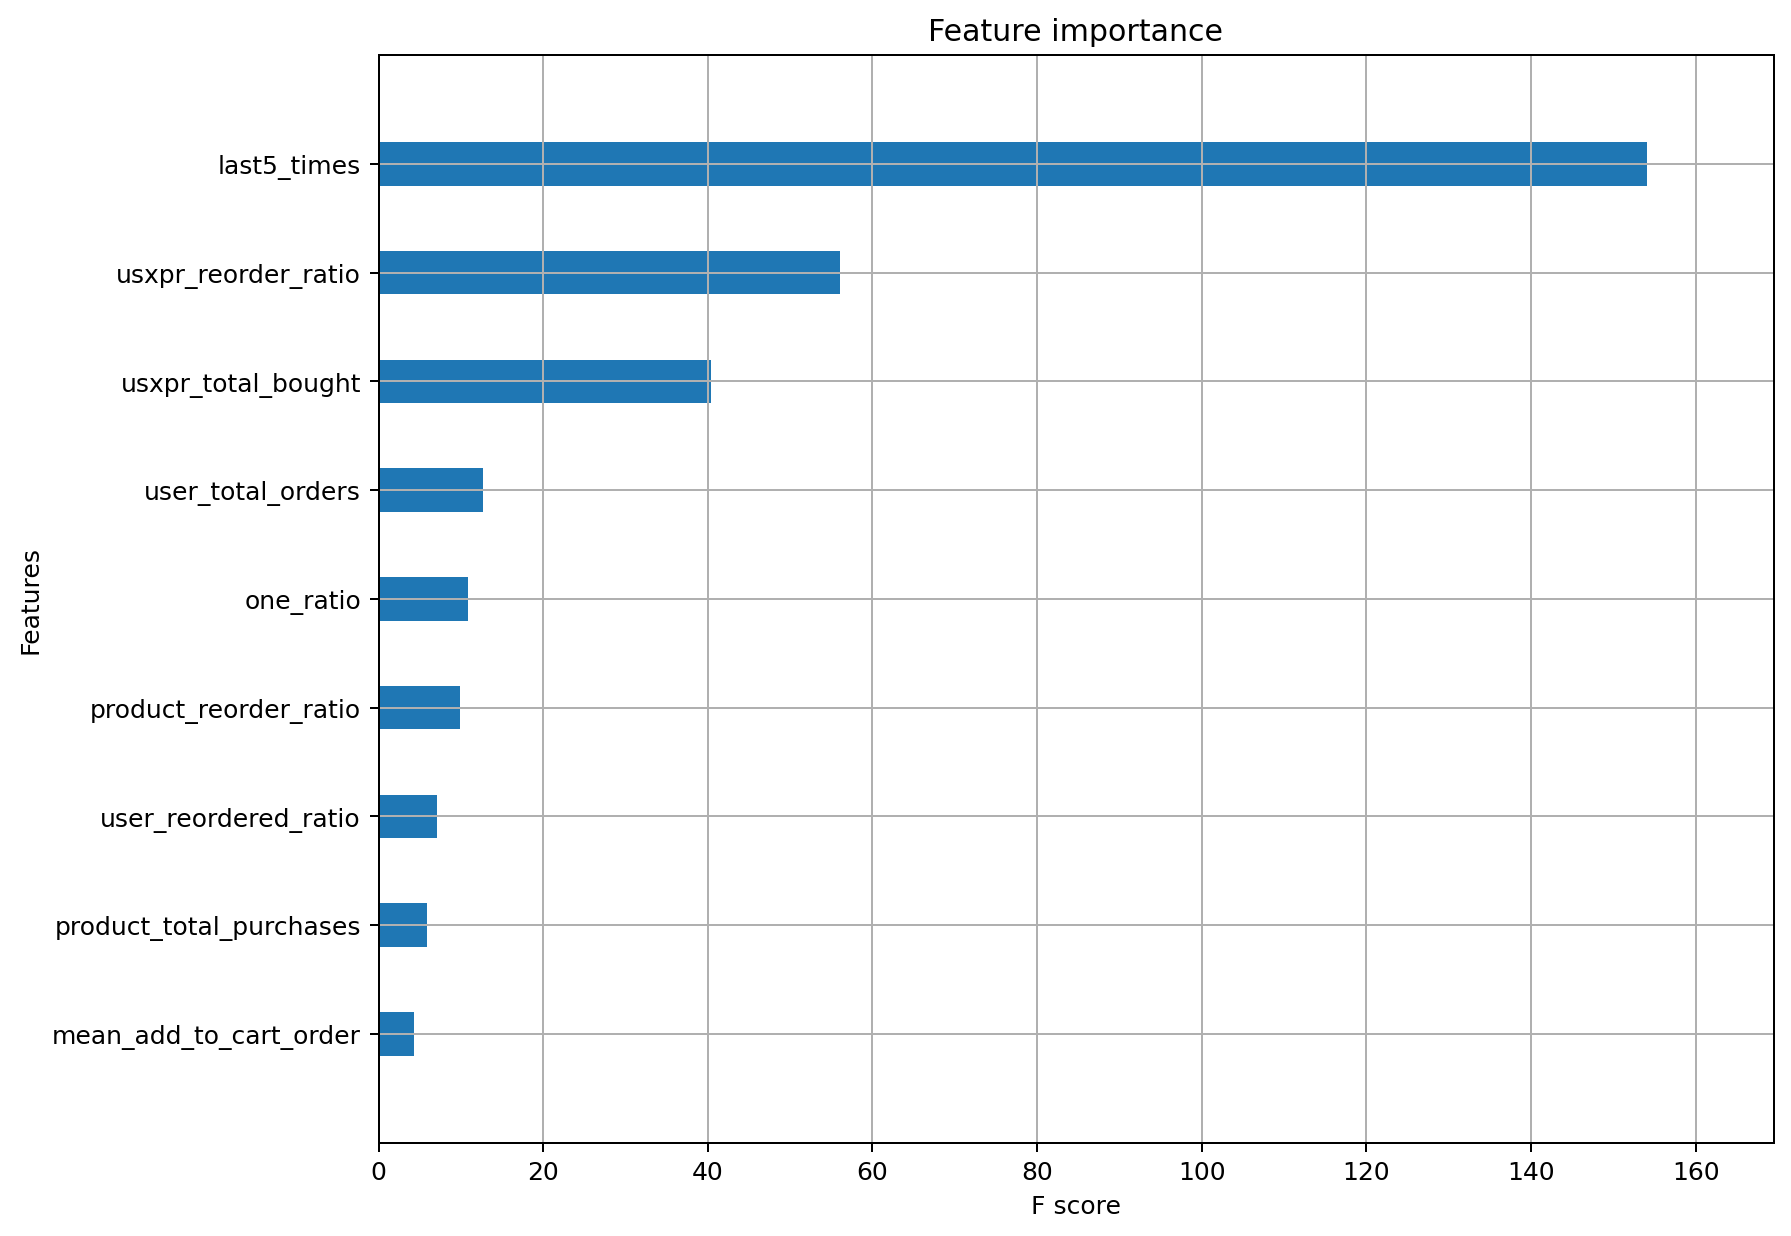

In [64]:
# Matplotlip inline
fig, ax = pyplot.subplots(figsize=(10, 8), dpi=180)
plot_importance(best, height=0.4, importance_type='gain', max_num_features=30, show_values=False, ax=ax)
pyplot.show()